# DEV

In [ ]:
+ name modes
+ tests

In [ ]:
"""
Higher order partial derivatives computation with respect to one or several tensor-like variables.
Taylor series function approximation (derivative table and series function representation).
Parametric fixed point computation.

Ivan Morozov, 2022-2023

"""
from __future__ import annotations

import torch

from multimethod import multimethod

from math import factorial
from math import prod

from functools import partial

from torch import Tensor

from typing import TypeAlias
from typing import Callable
from typing import Iterator
from typing import Optional
from typing import Union

Mapping: TypeAlias = Callable
Point  : TypeAlias = list[Tensor]
Delta  : TypeAlias = list[Tensor]
State  : TypeAlias = Tensor
Knobs  : TypeAlias = list[Tensor]
Table  : TypeAlias = list
Series : TypeAlias = dict[tuple[int, ...], Tensor]


def multinomial(*sequence:tuple[int, ...]) -> float:
    """
    Compute multinomial coefficient for a given sequence (n, m, ...) of non-negative integers
    (n + m + ...)! / (n! * m! * ... )

    Parameters
    ----------
    *sequence: tuple[int, ...], non-negative
        input sequence of integers

    Returns
    ------
    float

    """
    return factorial(sum(sequence)) / prod(map(factorial, sequence))


def flatten(array:tuple, *, target:type=tuple) -> Iterator:
    """
    Flatten a nested tuple (or other selected target type container)

    Parameters
    ----------
    array: tuple
        input nested tuple
    target: type, default=tuple
        target type to flatten

    Yields
    ------
    flattened tuple iterator (or selected target type container iterator)

    """
    if isinstance(array, target):
        for element in array:
            yield from flatten(element, target=target)
    else:
        yield array


def curry_apply(function:Callable, table:tuple[int, ...], *pars:tuple) -> Callable:
    """
    Curry apply
    
    Given f(x, y, ...) and table = map(len, (x, y, ...)) return g(*x, *y, ...) = f(x, y, ...)

    Parameters
    ----------
    function: Callable
        input function
    table: tuple[int, ...]
        map(len, (x, y, ...))
    *pars: tuple
        passed to input function

    Returns
    ------
    Callable

    """
    def clouser(*args:tuple):
        start = 0
        vecs = []
        for length in table:
            vecs.append(args[start:start + length])
            start += length
        return function(*vecs, *pars)
    return partial(clouser)


@multimethod
def derivative(order:int,
               function:Callable,
               *args:tuple,
               intermediate:bool=True,
               jacobian:Callable=torch.func.jacfwd) -> Union[Table, Tensor]:
    """
    Compute input function derivatives with respet to the first function argument upto a given order

    Note, if intermediate flag is ``False``, only the highest order derivative is returned

    Input function is expected to return a tensor or a (nested) list of tensors
    The first function argument is expected to be a tensor

    If the input function returns a tensor, output is called derivative table representation, [value, jacobian, hessian, ...]
    The first argument is called an evaluation point (State)

    Parameters
    ----------
    order: int, non-negative
        maximum derivative order
    function: Callable
        input function
    *args: tuple
        input function arguments
    intermediate: bool, default=True
        flag to return intermediate derivatives
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev

    Returns
    -------
    Union[Table, Tensor]
        function derivatives / derivative table representation

    """
    def local(x, *xs):
        y = function(x, *xs)
        return (y, y) if intermediate else y

    for _ in range(order):
        def local(x, *xs, local=local):
            if not intermediate:
                return jacobian(local, has_aux=False)(x, *xs)
            y, ys = jacobian(local, has_aux=True)(x, *xs)
            return y, (ys, y)

    if not intermediate:
        return local(*args)

    y, ys = local(*args)

    return list(flatten(ys, target=tuple))


@multimethod
def derivative(order:tuple[int, ...],
               function:Callable,
               *args:tuple,
               intermediate:bool=True,
               jacobian:Callable=torch.func.jacfwd) -> Union[Table, Tensor]:
    """
    Compute input function derivatives with respet to several first function arguments upto corresponding given orders

    Note, if intermediate flag is ``False``, only the highest (total) order derivative is returned

    Input function is expected to return a tensor or a (nested) list of tensors
    The first several function arguments are expected to be tensors

    If the input function returns a tensor, output is called derivative table representation
    List of several first arguments is called an evaluation point (``Point``)

    Parameters
    ----------
    order: tuple[int, ...], non-negative
        maximum derivative orders
    function: Callable
        input function
    *args:
        input function arguments
    intermediate: bool, default=True
        flag to return intermediate derivatives
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev

    Returns
    -------
    Union[Table, Tensor]
    function derivatives / derivative table representation

    """
    pars = [*args][len(order):]

    def fixed(*args):
        return function(*args, *pars)

    def build(order, value):
        def local(*args):
            return derivative(order, lambda x: fixed(*args, x), value, intermediate=intermediate, jacobian=jacobian)
        return local

    (order, value), *rest = zip(order, args)
    for degree, tensor in reversed(rest):
        def build(order, value, build=build(degree, tensor)):
            def local(*args):
                return derivative(order, lambda x: build(*args, x), value, intermediate=intermediate, jacobian=jacobian)
            return local

    return build(order, value)()


@multimethod
def derivative(order:int, function:Callable, point:Point, *pars:tuple, **kwargs:dict) -> Table:
    """ Compute input function derivatives at a given evaluation point upto a given order """
    return derivative(order, function, *point, *pars, **kwargs)


@multimethod
def derivative(order:tuple[int, ...], function:Callable, point:Point, *pars:tuple, **kwargs:dict) -> Table:
    """ Compute input function derivatives at a given evaluation point upto corresponding given orders """
    return derivative(order, function, *point, *pars, **kwargs)


@multimethod
def derivative(order:int, function:Callable, state:State, knobs:Knobs, *pars:tuple, **kwargs:dict) -> Table:
    """ Compute input function derivatives for given state and knobs upto a given order with respect to state """
    return derivative(order, function, state, *knobs, *pars, **kwargs)


@multimethod
def derivative(order:tuple[int, ...], function:Callable, state:State, knobs:Knobs, *pars:tuple, **kwargs:dict) -> Table:
    """ Compute input function derivatives for given state and knobs upto corresponding given orders with respect to state and knobs """
    return derivative(order, function, state, *knobs, *pars, **kwargs)


@multimethod
def signature(table:Table, *, factor:bool=False) -> Union[list[tuple[int, ...]], list[tuple[tuple[int, ...], float]]]:
    """
    Compute derivative table bottom elements signatures

    Note, signature elements corresponds to the bottom elements of a flattened input derivative table
    Bottom element signature is a tuple integers, derivative orders with respect to each tensor variable
    Optionaly return elements multiplication factors
    Given a signature (n, m, ...), corresponding multiplication factor is 1/n! * 1/m! * ...

    Parameters
    ----------
    table: Table
        input derivative table representation
    fator: bool, default=True
        flag to return elements multipliation factors

    Returns
    ----------
    Union[list[tuple[int, ...]], list[tuple[tuple[int, ...], float]]]
        bottom table elements signatures
    
    """
    return [*flatten([signature([i], subtable, factor=factor) for i, subtable in enumerate(table)], target=list)]


@multimethod
def signature(index:list[int], table:Table, *, factor:bool=False):
    return [signature(index + [i], subtable, factor=factor) for i, subtable in enumerate(table)]


@multimethod
def signature(index:list[int], table:Tensor, *, factor:bool=False):
    value = 1.0
    for i, count in enumerate(index):
        value *= 1.0/factorial(count)
    return tuple(index) if not factor else (tuple(index), value)


def get(table:Table, index:tuple[int, ...]) -> Union[Tensor, Table]:
    """
    Get derivative table element at a given (bottom) element signature

    Note, index can correspond to a bottom element or a subtable

    Parameters
    ----------
    table: Table
        input derivative table representation
    index: tuple[int, ...]
        element signature

    Returns
    ----------
    Union[Tensor, Table]
        element value

    """
    if isinstance(index, int):
        return table[index]

    *ns, n = index
    for i in ns:
        table = table[i]
    return table[n]


def set(table:Table, index:tuple[int, ...], value:Union[Tensor, Table]) -> None:
    """
    Set derivative table element at a given (bottom) element signature.

    Note, index can correspond to a bottom element or a subtable

    Parameters
    ----------
    table: Table
        input derivative table representation
    index: tuple[int, ...]
        element signature
    value: Union[Tensor, Table]
        element value

    Returns
    ----------
    None

    """
    if isinstance(index, int):
        table[index] = value
        return

    *ns, n = index
    for i in ns:
        table = table[i]
    table[n] = value


def apply(table:Table, index:tuple[int, ...], function:Callable) -> None:
    """
    Apply function (modifies element at index).

    Note, index can correspond to a bottom element or a subtable

    Parameters
    ----------
    table: Table
        input derivative table representation
    index: tuple[int, ...]
        element signature
    function: Callable
        function to apply

    Returns
    ----------
    None

    """
    value = get(table, index)
    set(table, index, function(value))


@multimethod
def index(dimension:int,
          order:int, *,
          dtype:torch.dtype=torch.int64,
          device:torch.device=torch.device('cpu')) -> Tensor:
    """
    Generate monomial index table with repetitions for a given dimension and order (total monomial degree)

    Note, output length is dimension**degree

    Parameters
    ----------
    dimension: int, positive
        monomial dimension (number of variables)
    order: int, non-negative
        derivative order (total monomial degree)
    dtype: torch.dtype, default=torch.int64
        data type
    device: torch.device, default=torch.device('cpu')
        data device

    Returns
    ----------
    Tensor
        monomial index table with repetitions

    """
    if order == 0:
        return torch.zeros((1, dimension), dtype=dtype, device=device)

    if order == 1:
        return torch.eye(dimension, dtype=dtype, device=device)

    unit = index(dimension, 1, dtype=dtype, device=device)
    keys = index(dimension, order - 1, dtype=dtype, device=device)

    return torch.cat([keys + i for i in unit])


@multimethod
def index(dimension:tuple[int, ...],
          order:tuple[int, ...], *,
          dtype:torch.dtype=torch.int64,
          device:torch.device=torch.device('cpu')) -> Tensor:
    """
    Generate monomial index table with repetitions for given dimensions and corresponding orders (total monomial degrees)

    Note, output length is product(dimension**degree)

    Parameters
    ----------
    dimension: tuple[int, ...], positive
        monomial dimensions
    order: tuple[int, ...], non-negative
        derivative orders (total monomial degrees)
    dtype: torch.dtype, default=torch.int64
        data type
    device: torch.device, default=torch.device('cpu')
        data device

    Returns
    ----------
    Tensor
        monomial index table with repetitions

    """
    def merge(total:tuple, *table:tuple) -> tuple:
        x, *xs = table
        return tuple(merge(total + i, *xs) for i in x) if xs else tuple(list(total + i) for i in x)

    x, *xs = [tuple(index(*pair).tolist()) for pair in zip(dimension + (0, ), order + (0, ))]

    return torch.tensor([*flatten(tuple(merge(i, *xs) for i in x))], dtype=dtype, device=device)


@multimethod
def series(dimension:tuple[int, ...],
           order:tuple[int, ...],
           table:Table) -> Series:
    """
    Generate series representation from a given derivative table representation

    Note, table is expected to represent a vector valued function

    Parameters
    ----------
    dimension: tuple[int, ...], positive
        dimensions
    order: tuple[int, ...], non-negative
        derivative orders
    table: Table
        derivative table representation

    Returns
    ----------
    Series

    """
    series = {}

    for (count, factor), array in zip(signature(table, factor=True), flatten(table, target=list)):
        if not all(i <= j for i, j in zip(count, order)):
            continue
        count = index(dimension, count)
        array = factor*array.permute(*reversed(range(len(array.shape)))).flatten().reshape(-1, len(array))
        for key, value in zip(count, array):
            key = tuple(key.tolist())
            if key not in series:
                series[key]  = value
            else:
                series[key] += value

    return series


@multimethod
def series(index:tuple[int, ...],
           function:Callable,
           *args:tuple,
           jacobian:Callable=torch.func.jacfwd) -> Series:
    """
    Generate series representation of a given input function upto a given monomial index

    c(i, j, k, ...) * x**i * y**j * z**k * ... => {..., (i, j, k, ...) : c(i, j, k, ...), ...}

    Note, input function arguments are expected to be scalar tensors
    Function is expected to return a vector tensor

    Parameters
    ----------
    index: tuple[int, ...], non-negative
        monomial index, (i, j, k, ...)
    function: Callable,
        input function
    *args: tuple
        input function arguments
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev

    Returns
    -------
    Series

    """
    return series((1, ) * len(args), index, derivative(index, function, *args, intermediate=True, jacobian=jacobian))


@multimethod
def series(index:list[tuple[int, ...]],
           function:Callable,
           *args:tuple,
           jacobian:Callable=torch.func.jacfwd) -> Series:
    """
    Generate series representation of a given input function for a given set of monomial indices

    c(i, j, k, ...) * x**i * y**j * z**k * ... => {..., (i, j, k, ...) : c(i, j, k, ...), ...}

    Note, input function arguments are expected to be scalar tensors
    Function is expected to return a vector tensor

    Parameters
    ----------
    index: list[tuple[int, ...]], non-negative
        list of monomial indices, [..., (i, j, k, ...), ...]
    function: Callable,
        input function
    *args: tuple
        input function arguments
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev

    Returns
    -------
    Series

    """
    def factor(*index:int) -> float:
        return 1.0 / prod(map(factorial, index))

    return {i: factor(*i) * derivative(i, function, *args, intermediate=False, jacobian=jacobian) for i in index}


@multimethod
def series(index:list[tuple[int, ...]], function:Callable, point:Point, *pars:tuple, jacobian:Callable=torch.func.jacfwd) -> Series:
    """ Generate series representation of a given input function for a given set of monomial indices """
    return series(index, function, *torch.cat(point), *pars, jacobian=jacobian)


@multimethod
def series(index:list[tuple[int, ...]], function:Callable, state:State, knobs:Knobs, *pars:tuple, jacobian:Callable=torch.func.jacfwd) -> Series:
    """ Generate series representation of a given input function for a given set of monomial indices """
    return series(index, function, *state, *torch.cat(knobs), *pars, jacobian=jacobian)


def merge(probe:Series, other:Series) -> Series:
    """
    Merge (sum) series

    Parameters
    ----------
    probe, other: Series
        input series to merge

    Returns
    -------
    Series

    """
    total = {key: value.clone() for key, value in probe.items()}
    for key, value in other.items():
        if key in total:
            total[key] += value
        else:
            total[key]  = value
    return total


def clean(probe:Series, *, epsilon:float=1.0E-16) -> Series:
    """
    Clean series

    Parameters
    ----------
    probe: Series
        input series to clean
    epsilon: float, non-negative
        clean epsilon

    Returns
    -------
    Series

    """
    return {key: value for key, value in probe.items() if torch.any(value > epsilon)}


def fetch(probe:Series, index:list[tuple[int, ...]]) -> Series:
    """
    Fetch series

    Parameters
    ----------
    probe: Series
        input series
    index: list[tuple[int, ...]], non-negative
        list of monomial indices, [..., (i, j, k, ...), ...]

    Returns
    -------
    Series

    """
    return {key: value for key, value in probe.items() if key in index}


def split(probe:Series) -> list[Series]:
    """
    (series operation) Split series

    Note, coefficient values are assumed to be vector tensors

    Parameters
    ----------
    probe: Series
        input series

    Returns
    -------
    list[Series]

    """
    return [dict(zip(probe.keys(), value)) for value in torch.stack([*probe.values()]).T]


@multimethod
def evaluate(table:Table,
             delta:Delta) -> Tensor:
    """
    Evaluate input derivative table representation at a given delta deviation

    Note, input table is expected to represent a vector or scalar valued function

    Parameters
    ----------
    table: Table
        input derivative table representation
    delta: Delta
        delta deviation

    Returns
    ----------
    Tensor

    """
    return sum(evaluate([i], subtable, delta) for i, subtable in enumerate(table))


@multimethod
def evaluate(index:list[int], table:Table, delta:Delta):
    return sum(evaluate(index + [i], subtable, delta) for i, subtable in enumerate(table))


@multimethod
def evaluate(index:list[int], table:Tensor, delta:Delta):
    total = 1.0
    for count, order in enumerate(index):
        total *= 1.0/factorial(order)
        value  = delta[count]
        if value.ndim > 0:
            for _ in range(order): table @= value
        else:
            for _ in range(order): table *= value
    return total*table


@multimethod
def evaluate(series:Series,
             delta:Delta,
             epsilon:Optional[float]=None) -> Tensor:
    """
    Evaluate series representation at a given deviation delta

    Note, input series is expected to represent a vector valued function
    For epsilon != None, fast evaluation is performed

    Parameters
    ----------
    series: Series
        input series representation
    delta: Delta
        delta deviation
    epsilon: Optional[float], non-negative, default=None
        fast series evaluation / tolerance epsilon

    Returns
    ----------
    Tensor

    """
    state = torch.cat(delta)

    if epsilon is not None:
        state = epsilon + state
        index = torch.tensor([*series.keys()], dtype=torch.int64, device=state.device)
        value = torch.stack([*series.values()])
        return (value.T*(state**index).prod(-1)).sum(-1)

    total, *_ = series.values()
    total = torch.zeros_like(total)
    for key, value in series.items():
        local = torch.ones_like(state).prod()
        for i, x in zip(key, state):
            for _ in range(i): local = x * local
        total = total + value * local
    return total


def table(dimension:tuple[int, ...],
          order:tuple[int, ...],
          series:Series, *,
          epsilon:Optional[float]=None,
          jacobian:Callable=torch.func.jacfwd) -> Table:
    """
    Generate derivative table representation from a given series representation

    Note, table is generated by taking derivatives of evaluated series at zero deviation delta.
    For epsilon != None can be used for fast series evaluation, but can generate incorrect table

    Parameters
    ----------
    dimension: tuple[int, ...], positive
        dimensions
    order: tuple[int, ...], non-negative
        maximum derivative orders
    series: Series
        input series representation
    epsilon: Optional[float], non-negative, default=None
        fast series evaluation / tolerance epsilon
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev

    Returns
    ----------
    Table

    """
    def function(*args):
        return evaluate(series, [*args], epsilon=epsilon)

    value, *_ = series.values()
    delta = [torch.zeros(i, dtype=value.dtype, device=value.device) for i in dimension]

    return derivative(order, function, delta, intermediate=True, jacobian=jacobian)


def identity(order:tuple[int, ...],
             point:Point, *,
             flag:bool=False,
             jacobian:Callable=torch.func.jacfwd) -> Union[Table, Series]:
    """
    Generate identity derivative table or identity series

    Note, identity table or series represent an identity mapping

    Parameters
    ----------
    order: tuple[int, ...], non-negative
        maximum derivative orders
    point: Point
        evaluation point
    flag: bool, default=False
        flag to return identity series instead of table
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev

    Returns
    ----------
    Union[Table, Series]
        identity derivative table or series

    """
    table = derivative(order, lambda x, *xs: x, point, intermediate=True, jacobian=jacobian)

    if not flag:
        return table

    return series(tuple(map(len, point)), order, table)


@multimethod
def propagate(dimension:tuple[int, ...],
              order:tuple[int, ...],
              data:Table,
              knobs:Knobs,
              mapping:Mapping,
              *pars:tuple,
              intermediate:bool=True,
              jacobian:Callable=torch.func.jacfwd) -> Union[Table, Tensor]:
    """
    Propagate derivative table representation through a given mapping

    Parameters
    ----------
    dimension: tuple[int, ...], positive
        dimensions
    order: tuple[int, ...], non-negative
        maximum derivative orders
    data: Table
        input derivative table
    knobs: Knobs
        input parametric variables
    mapping: Mapping
        input mapping
    *pars: tuple
        additional mapping fixed arguments
    intermediate: bool, default=True
        flag to return intermediate derivatives
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev

    Returns
    ----------
    Union[Table, Tensor]

    """
    def auxiliary(*args) -> Tensor:
        state, *args = args
        state = evaluate(data, [state, *args])
        args = [arg + knob for arg, knob in zip(args, knobs)]
        return mapping(state, *args, *pars)

    value, *_ = flatten(data, target=list)
    delta = [torch.zeros(i, dtype=value.dtype, device=value.device) for i in dimension]

    return derivative(order, auxiliary, delta, intermediate=intermediate, jacobian=jacobian)


@multimethod
def propagate(dimension:tuple[int, ...],
              order:tuple[int, ...],
              data:Series,
              knobs:Knobs,
              mapping:Mapping,
              *pars:tuple,
              epsilon:Optional[float]=None,
              jacobian:Callable=torch.func.jacfwd) -> Series:
    """
    Propagate series representation through a given mapping

    Note, input series are expected to contain all indices

    Parameters
    ----------
    dimension: tuple[int, ...], positive
        dimensions
    order: tuple[int, ...], non-negative
        maximum derivative orders
    data: Series
        input series
    knobs: Knobs
        input parametric variables
    mapping: Mapping
        input mapping
    *pars: tuple
        additional mapping fixed arguments
    epsilon: Optional[float], non-negative, default=None
        fast series evaluation / tolerance epsilon
    intermediate: bool, default=True
        flag to return intermediate derivatives
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev

    Returns
    ----------
    Series

    """
    def auxiliary(*args) -> Tensor:
        state, *args = torch.stack([*args]).split(dimension)
        state = evaluate(data, [state, *args], epsilon=epsilon)
        args = [arg + knob for arg, knob in zip(args, torch.cat(knobs))]
        return mapping(state, *args, *pars)

    value, *_ = series.values()
    delta = torch.cat([torch.zeros(i, dtype=value.dtype, device=value.device) for i in dimension])

    return series([*data.keys()], auxiliary, *delta, jacobian=jacobian)


def newton(function:Mapping,
           guess:Tensor,
           *pars:tuple,
           solve:Callable=lambda jacobian, value: torch.linalg.pinv(jacobian) @ value,
           roots:Optional[Tensor]=None,
           jacobian:Callable=torch.func.jacfwd) -> Tensor:
    """
    Perform one Newton root search step

    Parameters
    ----------
    function: Mapping
        input function
    guess: Tensor
        initial guess
    *pars:
        additional function arguments
    solve: Callable, default=lambda jacobian, value: torch.linalg.pinv(jacobian) @ value
        linear solver
    roots: Optional[Tensor], default=None
        known roots to avoid
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev

    Returns
    ----------
    Tensor

    """
    def auxiliary(x:Tensor, *xs) -> Tensor:
        return function(x, *xs)/(roots - x).prod(-1)

    value, jacobian = derivative(1, function if roots is None else auxiliary, guess, *pars, jacobian=jacobian)

    return guess - solve(jacobian, value)


def fixed_point(limit:int,
                function:Mapping,
                guess:Tensor,
                *pars:tuple,
                power:int=1,
                epsilon:Optional[float]=None,
                solve:Callable=lambda jacobian, value: torch.linalg.pinv(jacobian) @ value,
                roots:Optional[Tensor]=None,
                jacobian:Callable=torch.func.jacfwd) -> Tensor:
    """
    Estimate (dynamical) fixed point

    Note, can be mapped over initial guess and/or other input function arguments if epsilon = None

    Parameters
    ----------
    limit: int, positive
        maximum number of newton iterations
    function: Mapping
        input mapping
    guess: Tensor
        initial guess
    *pars: tuple
        additional function arguments
    power: int, positive, default=1
        function power / fixed point order
    epsilon: Optional[float], default=None
        tolerance epsilon
    solve: Callable, default=lambda jacobian, value: torch.linalg.pinv(jacobian) @ value
        linear solver
    roots: Optional[Tensor], default=None
        known roots to avoid
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev

    Returns
    ----------
    Tensor

    """
    def auxiliary(state:Tensor) -> Tensor:
        local = torch.clone(state)
        for _ in range(power):
            local = function(local, *pars)
        return state - local

    point = torch.clone(guess)

    for count in range(limit):
        point = newton(auxiliary, point, solve=solve, roots=roots, jacobian=jacobian)
        error = (point - guess).abs().max()
        guess = torch.clone(point)
        if epsilon is not None and error < epsilon:
            break

    return point


def check_point(power:int,
                function:Mapping,
                point:Tensor,
                *pars:tuple,
                epsilon:float=1.0E-12) -> bool:
    """
    Check fixed point candidate to have given prime period

    Parameters
    ----------
    power: int, positive
        function power / prime period
    function: Mapping
        input function
    point: Tensor
        fixed point candidate
    *pars:tuple
        additional function arguments
    epsilon: float, default=1.0E-12
        tolerance epsilon

    Returns
    ----------
    bool

    """
    def auxiliary(state:Tensor, power:int) -> Tensor:
        local = torch.clone(state)
        table = [local]
        for _ in range(power):
            local = function(local, *pars)
            table.append(local)
        return torch.stack(table)

    if power == 1:
        return True

    points = auxiliary(point, power)
    start, *points, end = points

    if (start - end).norm() > epsilon:
        return False

    return not torch.any((torch.stack(points) - point).norm(dim=-1) < epsilon)


def clean_point(power:int,
                function:Mapping,
                point:Tensor,
                *pars:tuple,
                epsilon:float=1.0E-12) -> bool:
    """
    Clean fixed point candidates

    Parameters
    ----------
    power: int, positive
        function power / prime period
    function: Mapping
        input function
    point: Tensor
        fixed point candidates
    *pars:tuple
        additional function arguments
    epsilon: float, optional, default=1.0E-12
        tolerance epsilon

    Returns
    ----------
    bool

    """
    point = point[torch.all(point.isnan().logical_not(), dim=1)]
    point = torch.stack([candidate for candidate in point if check_point(power, function, candidate, *pars, epsilon=epsilon)])

    prime = []
    table = []

    for candidate in point:

        value = torch.linalg.eigvals(matrix(power, function, candidate, *pars))
        value = torch.stack(sorted(value, key=torch.norm))

        if not prime:
            prime.append(candidate)
            table.append(value)
            continue

        if all((torch.stack(prime) - candidate).norm(dim=-1) > epsilon):
            if all((torch.stack(table) - value).norm(dim=-1) > epsilon):
                prime.append(candidate)
                table.append(value)

    return torch.stack(prime)


def chain_point(power:int,
                function:Mapping,
                point:Tensor,
                *pars:tuple) -> Tensor:
    """
    Generate chain for a given fixed point.

    Note, can be mapped over point

    Parameters
    ----------
    power: int, positive
        function power
    function: Mapping
        input function
    point: Tensor
        fixed point
    *pars: tuple
        additional function arguments

    Returns
    ----------
    Tensor

    """
    def auxiliary(state:Tensor) -> Tensor:
        local = torch.clone(state)
        table = [local]
        for _ in range(power - 1):
            local = function(local, *pars)
            table.append(local)
        return torch.stack(table)

    return auxiliary(point)


def matrix(power:int,
           function:Mapping,
           point:Tensor,
           *pars:tuple,
           jacobian:Callable=torch.func.jacfwd) -> Tensor:
    """
    Compute (monodromy) matrix around given fixed point.

    Parameters
    ----------
    power: int, positive
        function power / prime period
    function: Mapping
        input function
    point: Tensor
        fixed point candidate
    *pars: tuple
        additional function arguments
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev

    Returns
    ----------
    Tensor

    """
    def auxiliary(state:Tensor) -> Tensor:
        local = torch.clone(state)
        for _ in range(power):
            local = function(local, *pars)
        return local

    return derivative(1, auxiliary, point, intermediate=False, jacobian=jacobian)


def parametric_fixed_point(order:tuple[int, ...],
                           state:State,
                           knobs:Knobs,
                           function:Mapping,
                           *pars:tuple,
                           power:int=1,
                           solve:Callable=lambda jacobian, value: torch.linalg.pinv(jacobian) @ value,
                           jacobian:Callable=torch.func.jacfwd) -> Table:
    """
    Compute parametric fixed point.

    Parameters
    ----------
    order: tuple[int, ...], non-negative
        knobs derivative orders
    state: State
        state fixed point
    knobs: Knobs
        knobs value
    function:Callable
        input function
    *pars: tuple
        additional function arguments
    power: int, positive, default=1
        function power
    solve: Callable, default=lambda jacobian, value: torch.linalg.pinv(jacobian) @ value
        linear solver
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev

    Returns
    ----------
    Table

    """
    def auxiliary(*point) -> State:
        state, *knobs = point
        for _ in range(power):
            state = function(state, *knobs, *pars)
        return state

    def objective(value:Tensor, shape, index:tuple[int, ...]) -> Tensor:
        value = value.reshape(*shape)
        set(table, index, value)
        local = propagate(dimension, index, table, knobs, auxiliary, intermediate=False, jacobian=jacobian)
        return (value - local).flatten()

    dimension = (len(state), *(len(knob) for knob in knobs))
    order = (0, *order)

    table = identity(order, [state] + knobs, jacobian=jacobian)
    _, *array = signature(table)

    for index in array:
        guess = get(table, index)
        value = newton(objective, guess.flatten(), guess.shape, index, solve=solve, jacobian=jacobian).reshape(*guess.shape)
        set(table, index, value.reshape(*guess.shape))

    return table


class Jet():
    """
    Convenience class to work with jets (evaluation point & derivative table)

    Returns
    ----------
    Jet class instance.

    Parameters
    ----------
    dimension: tuple[int, ...], positive
        dimensions
    order: tuple[int, ...], non-negative
        maximum derivative orders
    initialize : bool
        flag to initialize identity derivative table, optional, default=True
    point: Optional[Point]
        evaluation point, default=None
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev
    dtype: torch.dtype, default=torch.float64
        data type
    device: torch.device, default=torch.device('cpu')
        data device

    Attributes
    ----------
    dimension: tuple[int, ...], positive
        dimensions
    order: tuple[int, ...], non-negative
        maximum derivative orders
    initialize : bool
        flag to initialize identity derivative table, optional, default=True
    point: Point
        evaluation point, default=None
    jacobian: Callable, default=torch.func.jacfwd
        torch.func.jacfwd or torch.func.jacrev
    dtype: torch.dtype, default=torch.float64
        data type
    device: torch.device, default=torch.device('cpu')
        data device
    state: State
        state
    knobs: Knobs
        knobs
    table: Table
        table representation
    series: Series
         series representation
    signature: list[tuple[int, ...]]
        derivative table elements bottom elements signatures
    parametetric: Table
        parametric table

    """
    def __init__(self,
                 dimension:tuple[int, ...],
                 order:tuple[int, ...], *,
                 initialize:bool=True,
                 point:Optional[Point]=None,
                 jacobian:Callable=torch.func.jacfwd,
                 dtype:torch.dtype=torch.float64,
                 device:torch.device=torch.device('cpu')) -> None:
        """
        Jet initialization

        Parameters
        ----------
        dimension: tuple[int, ...], positive
            dimensions
        order: tuple[int, ...], non-negative
            maximum derivative orders
        initialize : bool
            flag to initialize identity derivative table, optional, default=True
        point: Optional[Point]
            evaluation point
        jacobian: Callable, default=torch.func.jacfwd
            torch.func.jacfwd or torch.func.jacrev
        dtype: torch.dtype, default=torch.float64
            data type
        device: torch.device, default=torch.device('cpu')
            data device

        Returns
        ----------
        None

        """
        self.dimension:tuple[int, ...] = dimension
        self.order:tuple[int, ...] = order
        self.initialize:bool = initialize
        self.point:Point = point
        self.jacobian:Callable = jacobian
        self.dtype:torch.dtype = dtype
        self.device:torch.device = device

        if self.point is None:
            self.point = [torch.zeros(i, dtype=self.dtype, device=self.device) for i in self.dimension]

        state, *knobs = self.point
        self.state:State = state
        self.knobs:Knobs = knobs

        self.table:Table = None if self.initialize is None else identity(self.order, self.point, flag=False, jacobian=self.jacobian)


    def evaluate(self, delta:Delta) -> Tensor:
        """
        Evaluate jet derivative table at a given delta deviation

        Parameters
        ----------
        delta: Delta
            delta deviation

        Returns
        ----------
        Tensor

        """
        return evaluate(self.table, delta)


    @property
    def signature(self) -> list[tuple[int, ...]]:
        """
        Compute derivative table elements bottom elements signatures

        Parameters
        ----------
        None

        Returns
        ----------
        list[tuple[int, ...]]
            bottom table elements signatures

        """
        return signature(self.table, factor=False)


    @property
    def series(self) -> Series:
        """
        Series representation

        Parameters
        ----------
        None

        Returns
        ----------
        Series

        """
        return series(self.dimension, self.order, self.table)


    @property
    def parametetric(self) -> Table:
        """
        Get parametric table (first subtable)

        Parameters
        ----------
        None

        Returns
        ----------
        Table

        """
        table, *_ = self.table
        return table


    @parametetric.setter
    def parametetric(self, value:Table) -> None:
        """
        Set parametric table (first subtable)

        Parameters
        ----------
        value: Table
            parametric table

        Returns
        ----------
        None

        """
        set(self.table, (0, ), value)


    @classmethod
    def from_mapping(cls,
                     dimension:tuple[int, ...],
                     order:tuple[int, ...],
                     point:Point,
                     function:Mapping,
                     *args:tuple,
                     jacobian:Callable=torch.func.jacfwd,
                     dtype:torch.dtype=torch.float64,
                     device:torch.device=torch.device('cpu')) -> Jet:
        """
        Jet initialization from mapping

        Parameters
        ----------
        dimension: tuple[int, ...], positive
            dimensions
        order: tuple[int, ...], non-negative
            maximum derivative orders
        point: Point
            evaluation point
        function: Mapping
            input function
        *args: tuple
            additional function arguments
        jacobian: Callable, default=torch.func.jacfwd
            torch.func.jacfwd or torch.func.jacrev
        dtype: torch.dtype, default=torch.float64
            data type
        device: torch.device, default=torch.device('cpu')
            data device

        Returns
        ----------
        Jet

        """
        jet = cls(dimension, order, initialize=False, point=point, jacobian=jacobian, dtype=dtype, device=device)
        jet.table:Table = derivative(order, function, *point, *args, intermediate=True, jacobian=jacobian)
        return jet


    @classmethod
    def from_table(cls,
                   dimension:tuple[int, ...],
                   order:tuple[int, ...],
                   point:Point,
                   table:Table,
                   jacobian:Callable=torch.func.jacfwd,
                   dtype:torch.dtype=torch.float64,
                   device:torch.device=torch.device('cpu')) -> Jet:
        """
        Jet initialization from table

        Parameters
        ----------
        dimension: tuple[int, ...], positive
            dimensions
        order: tuple[int, ...], non-negative
            maximum derivative orders
        point: Point
            evaluation point
        table: Table
            input (derivative) table
        jacobian: Callable, default=torch.func.jacfwd
            torch.func.jacfwd or torch.func.jacrev
        dtype: torch.dtype, default=torch.float64
            data type
        device: torch.device, default=torch.device('cpu')
            data device

        Returns
        ----------
        Jet

        """
        jet = cls(dimension, order, initialize=False, point=point, jacobian=jacobian, dtype=dtype, device=device)
        jet.table:Table = table
        return jet


    @classmethod
    def from_series(cls,
                    dimension:tuple[int, ...],
                    order:tuple[int, ...],
                    point:Point,
                    series:Series,
                    jacobian:Callable=torch.func.jacfwd,
                    dtype:torch.dtype=torch.float64,
                    device:torch.device=torch.device('cpu')) -> Jet:
        """
        Jet initialization from series

        Parameters
        ----------
        dimension: tuple[int, ...], positive
            dimensions
        order: tuple[int, ...], non-negative
            maximum derivative orders
        point: list[Tensor]
            evaluation point
        series: Series
            input series
        jacobian: Callable, default=torch.func.jacfwd
            torch.func.jacfwd or torch.func.jacrev
        dtype: torch.dtype, default=torch.float64
            data type
        device: torch.device, default=torch.device('cpu')
            data device

        Returns
        ----------
        Jet

        """
        jet = cls(dimension, order, initialize=False, point=point, jacobian=jacobian, dtype=dtype, device=device)
        jet.table:Table = table(dimension, order, series, jacobian=jacobian, dtype=dtype, device=device)
        return jet


    def propagate(self,
                  function:Mapping,
                  *pars:tuple) -> Jet:
        """
        Propagate jet.

        Parameters
        ----------
        function: Mapping
            input function
        knobs: Knobs
            input function knobs
        *pars: tuple
            additional function arguments

        Returns
        ----------
        Jet

        """
        table = propagate(self.dimension, self.order, self.table, self.knobs, function, *pars, intermediate=True, jacobian=self.jacobian)
        return self.from_table(self.dimension, self.order, self.point, table, jacobian=self.jacobian, dtype=self.dtype, device=self.device)


    def compliant(self, other:Jet) -> bool:
        """
        Check jets are compliant (can be composed)

        Parameters
        ----------
        other: Jet
            other jet

        Returns
        ----------
        bool

        """
        if not all(i == j for i, j in zip(self.dimension, other.dimension)):
            return False

        if not all(i == j for i, j in zip(self.order, other.order)):
            return False

        return True


    def compose(self, other:Jet) -> Jet:
        """
        Compose jets (evaluate other jet at self jet)

        Parameters
        ----------
        other: Jet
            other jet

        Returns
        ----------
        Jet

        """
        def auxiliary(*args) -> Tensor:
            return other.evaluate([*args])

        return self.propagate(auxiliary)


    def __bool__(self) -> bool:
        """
        Check if table is not None

        Parameters
        ----------
        None

        Returns
        ----------
        bool

        """
        return self.table is not None


    def __eq__(self, other:Jet) -> bool:
        """
        Compare jets

        Parameters
        ----------
        other: Jet
            other jet

        Returns
        ----------
        bool

        """
        if not self.compliant(other):
            return False

        if all(torch.allclose(x, y) for x, y in zip(self.series.values(), other.series.values())):
            return True

        return False


    def __getitem__(self, index:tuple[int, ...]) -> Union[Tensor, Table]:
        """
        Get item (derivative table bottom element or subtable)

        Parameters
        ----------
        index: tuple[int, ...]
            index

        Returns
        ----------
        Union[Tensor, Table]

        """
        return get(self.table, index)


    def __setitem__(self, index:tuple[int, ...], value:Union[Tensor, Table]) -> None:
        """
        Set item (derivative table bottom element or subtable)

        Parameters
        ----------
        index: tuple[int, ...]
            index
        value: Union[Tensor, Table]
            value to set

        Returns
        ----------
        None

        """
        set(self.table, index, value)


    def __iter__(self):
        """
        Jet iteration (use for unpacking)

        """
        return flatten(self.table, target=list)


    def __len__(self) -> int:
        """
        Jet length (signature length / number of tensors)

        Parameters
        ----------
        None

        Returns
        ----------
        int

        """
        return len(self.signature)


    def __call__(self, delta:Delta) -> torch.Tensor:
        """
        Evaluate jet derivative table at a given delta deviation

        Parameters
        ----------
        delta: Delta
            delta deviation

        Returns
        ----------
        Tensor

        """
        return self.evaluate(delta)


    def __matmul__(self, other:Jet) -> Jet:
        """
        Compose jets (evaluate other jet at self jet)

        Parameters
        ----------
        other: Jet
            other jet

        Returns
        ----------
        Jet

        """
        return self.compose(other)


    def __repr__(self) -> str:
        """
        String representation.

        Parameters
        ----------
        None

        Returns
        ----------
        str

        """
        return f'Jet({self.dimension}, {self.order})'

# Example-01: Derivative

In [1]:
# Given an input function, its higher order (partial) derivatives with respect to one or sevaral tensor arguments can be computed using forward or reverse mode automatic differentiation
# Derivative orders can be different for each tensor argument
# Input function is expected to return a tensor or a (nested) list of tensors

# Derivatives are computed by nesting torch.func jacobian functions
# For higher order derivatives, this results in growing redundant computations, forward mode is more efficient in this case

# If the input function returns a tensor, the output is referred as derivative table representation
# This representation can be evaluated near given evaluation point if the input function returns a scalar or a vector
# Table representation is a (nested) list of tensors, it can be used as a (redundant) function representation near given evaluation point
# Table structure for f(x), f(x, y) and f(x, y, z) is shown bellow (similar structure holds for a function with more aruments)

# f(x)
# t(f, x)
# [f, Dx f, Dxx f, ...]

# f(x, y)
# t(f, x, y)
# [
#     [    f,     Dy f,     Dyy f, ...],
#     [ Dx f,  Dx Dy f,  Dx Dyy f, ...],
#     [Dxx f, Dxx Dy f, Dxx Dyy f, ...],
#     ...
# ]

# f(x, y, z)
# t(f, x, y, z)
# [
#     [
#         [         f,          Dz f,          Dzz f, ...],
#         [      Dy f,       Dy Dz f,       Dy Dzz f, ...],
#         [     Dyy f,      Dyy Dz f,      Dyy Dzz f, ...],
#         ...
#     ],
#     [
#         [      Dx f,       Dx Dz f,       Dx Dzz f, ...],
#         [   Dx Dy f,    Dx Dy Dz f,    Dx Dy Dzz f, ...],
#         [  Dx Dyy f,   Dx Dyy Dz f,   Dx Dyy Dzz f, ...],
#         ...
#     ],
#     [
#         [    Dxx f,     Dxx Dz f,     Dxx Dzz f, ...],
#         [ Dxx Dy f,  Dxx Dy Dz f,  Dxx Dy Dzz f, ...],
#         [Dxx Dyy f, Dxx Dyy Dz f, Dxx Dyy Dzz f, ...],
#         ...
#     ],
#     ...
# ]

In [2]:
# Import

import torch

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Basic derivative interface

# nd.derivative(
#     order:int,                             # derivative order
#     function:Callable,                     # input function
#     *args,                                 # function(*args) = function(x:Tensor, ...)
#     intermediate:bool = True,              # flag to return intermediate derivatives
#     jacobian:Callable = torch.func.jacfwd  # torch.func.jacfwd or torch.func.jacfrev
# )

# nd.derivative(
#     order:tuple[int, ...],                 # derivative orders
#     function:Callable,                     # input function
#     *args,                                 # function(*args) = function(x:Tensor, y:Tensor, z:Tensor, ...)
#     intermediate:bool = True,              # flag to return intermediate derivatives
#     jacobian:Callable = torch.func.jacfwd  # torch.func.jacfwd or torch.func.jacfrev
# )

In [5]:
# Derivative

# Input:  scalar
# Output: scalar

# Set test function
# Note, the first function argument is a scalar tensor
# Input function can have other additional arguments
# Other arguments are not used in computation of derivatives

def fn(x, a, b, c, d, e, f):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5

# Set derivative order

n = 5

# Set evaluation point

x = torch.tensor(0.0, dtype=dtype, device=device)

# Set fixed parameters

a, b, c, d, e, f = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=dtype, device=device)

# Compute n'th derivative

value = nd.derivative(n, fn, x, a, b, c, d, e, f, intermediate=False, jacobian=torch.func.jacfwd)
print(value.cpu().numpy().tolist())

# Compute all derivatives upto given order
# Note, function value itself is referred as zeros order derivative
# Since function returns a tensor, output is a list of tensors

values = nd.derivative(n, fn, x, a, b, c, d, e, f, intermediate=True, jacobian=torch.func.jacfwd)
print(*[value.cpu().numpy().tolist() for value in values], sep=', ')

# Note, intermediate flag (default=True) can be used to return all derivatives
# For jacobian parameter, torch.func.jacfwd or torch.func.jacrev functions can be passed

# Evaluate derivative table representation for a given deviation from the evaluation point

dx = torch.tensor(1.0, dtype=dtype, device=device)
print(nd.evaluate(nd.derivative(n, fn, x, a, b, c, d, e, f) , [dx]).cpu().numpy().tolist())
print(fn(x + dx, a, b, c, d, e, f).cpu().numpy().tolist())

120.0
1.0, 1.0, 2.0, 6.0, 24.0, 120.0
6.0
6.0


In [6]:
# Derivative

# Input:  vector
# Output: scalar

# Set test function
# Note, the first function argument is a vector tensor
# Input function can have other additional arguments
# Other arguments are not used in computation of derivatives

def fn(x, a, b, c):
    x1, x2 = x
    return a + b*(x1 - 1)**2 + c*(x2 + 1)**2

# Set derivative order

n = 2

# Set evaluation point

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)

# Set fixed parameters

a, b, c = torch.tensor([1.0, 1.0, 1.0], dtype=dtype, device=device)

# Compute only n'th derivative
# Note, for given input & output the result is hessian

value = nd.derivative(n, fn, x, a, b, c, intermediate=False, jacobian=torch.func.jacfwd)
print(value.cpu().numpy().tolist())

# Compute all derivatives upto given order
# Note, fuction value itself is referred as zeros order derivative
# Output is a list of tensors (value, jacobian, hessian, ...)

values = nd.derivative(n, fn, x, a, b, c, intermediate=True, jacobian=torch.func.jacfwd)
print(*[value.cpu().numpy().tolist() for value in values], sep=', ')

# Compute jacobian and hessian with torch.func

print(fn(x, a, b, c).cpu().numpy().tolist(), 
      torch.func.jacfwd(lambda x: fn(x, a, b, c))(x).cpu().numpy().tolist(), 
      torch.func.hessian(lambda x: fn(x, a, b, c))(x).cpu().numpy().tolist(), 
      sep=', ')

# Evaluate derivative table representation for a given deviation from the evaluation point

dx = torch.tensor([+1.0, -1.0], dtype=dtype, device=device)
print(nd.evaluate(values, [dx]).cpu().numpy())
print(fn(x + dx, a, b, c).cpu().numpy())

# Evaluate can be mapped over a set of deviation values

print(torch.func.vmap(lambda x: nd.evaluate(values, [x]))(torch.stack(5*[dx])).cpu().numpy().tolist())

# Derivative can be mapped over a set of evaluation points
# Note, the inputt function is expeted to return a tensor

print(torch.func.vmap(lambda x: nd.derivative(1, fn, x, a, b, c, intermediate=False))(torch.stack(5*[x])).cpu().numpy().tolist())

[[2.0, 0.0], [0.0, 2.0]]
3.0, [-2.0, 2.0], [[2.0, 0.0], [0.0, 2.0]]
3.0, [-2.0, 2.0], [[2.0, 0.0], [0.0, 2.0]]
1.0
1.0
[1.0, 1.0, 1.0, 1.0, 1.0]
[[-2.0, 2.0], [-2.0, 2.0], [-2.0, 2.0], [-2.0, 2.0], [-2.0, 2.0]]


In [7]:
# Derivative

# Input:  vector
# Output: vector

# Set test function
# Note, the first function argument is a vector tensor
# Input function can have other additional arguments
# Other arguments (if any) are not used in computation of derivatives

def fn(x):
    x1, x2 = x
    X1 = 1.0*x1 + 2.0*x2
    X2 = 3.0*x1 + 4.0*x2
    X3 = 5.0*x1 + 6.0*x2
    return torch.stack([X1, X2, X3])

# Set derivative order

n = 1

# Set evaluation point

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)

# Compute derivatives

values = nd.derivative(n, fn, x)
print(*[value.cpu().numpy().tolist() for value in values], sep=', ')
print()

# Evaluate derivative table representation for a given deviation from the evaluation point

dx = torch.tensor([+1, -1], dtype=dtype, device=device)
print(nd.evaluate(values, [dx]).cpu().numpy().tolist())
print(fn(x + dx).cpu().numpy().tolist())

[0.0, 0.0, 0.0], [[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]]

[-1.0, -1.0, -1.0]
[-1.0, -1.0, -1.0]


In [8]:
# Derivative

# Input:  tensor
# Output: tensor

# Set test function

def fn(x):
    return 1 + x + x**2 + x**3

# Set derivative order

n = 3

# Set evaluation point

x = torch.zeros((1, 2, 3), dtype=dtype, device=device)

# Compute derivatives
# Note, output is a list of tensors

values = nd.derivative(n, fn, x)
print(*[list(value.shape) for value in values], sep='\n')

# Evaluate derivative table representation for a given deviation from the evaluation point
# Note, evaluate function works with scalar or vector tensor input
# One should compute derivatives of a wrapped function and reshape the result of evaluate

# Set wrapped function

def gn(x, shape):
    return fn(x.reshape(shape)).flatten()

print(fn(x).cpu().numpy().tolist())
print(gn(x.flatten(), x.shape).reshape(x.shape).cpu().numpy().tolist())

# Compute derivatives

values = nd.derivative(n, gn, x.flatten(), x.shape)

# Set deviation value

dx = torch.ones_like(x)

# Evaluate

print(nd.evaluate(values, [dx.flatten()]).reshape(x.shape).cpu().numpy().tolist())
print(gn((x + dx).flatten(), x.shape).reshape(x.shape).cpu().numpy().tolist())
print(fn(x + dx).cpu().numpy().tolist())

[1, 2, 3]
[1, 2, 3, 1, 2, 3]
[1, 2, 3, 1, 2, 3, 1, 2, 3]
[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]
[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]]
[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]]
[[[4.0, 4.0, 4.0], [4.0, 4.0, 4.0]]]
[[[4.0, 4.0, 4.0], [4.0, 4.0, 4.0]]]
[[[4.0, 4.0, 4.0], [4.0, 4.0, 4.0]]]


In [9]:
# Derivative

# Input:  vector
# Output: nested list of tensors

# Set test function

def fn(x):
    x1, x2, x3, x4, x5, x6 = x
    X1 = 1.0*x1 + 2.0*x2 + 3.0*x3
    X2 = 4.0*x4 + 5.0*x5 + 6.0*x6
    return [torch.stack([X1]), [torch.stack([X2])]]

# Set derivative order

n = 1

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)

# Compute derivatives

values = nd.derivative(n, fn, x, intermediate=False)

In [10]:
# Derivative

# Input:  vector, vector, vector
# Output: vector

# Set test function

def fn(x, y, z):
    x1, x2 = x
    y1, y2 = y
    z1, z2 = z
    return torch.stack([(x1 + x2)*(y1 + y2)*(z1 + z2)])

# Set derivative orders for x, y and z

nx, ny, nz = 1, 1, 1

# Set evaluation point
# Note, evaluation point is a list of tensors

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
y = torch.tensor([0.0, 0.0], dtype=dtype, device=device)
z = torch.tensor([0.0, 0.0], dtype=dtype, device=device)

# Compute n'th derivativ

value = nd.derivative((nx, ny, nz), fn, x, y, z, intermediate=False)
print(value.cpu().numpy().tolist())

# Compute all derivatives upto given order

values = nd.derivative((nx, ny, nz), fn, x, y, z, intermediate=True)

# Evaluate derivative table representation for a given deviation from the evaluation point

dx = torch.tensor([1.0, 1.0], dtype=dtype, device=device)
dy = torch.tensor([1.0, 1.0], dtype=dtype, device=device)
dz = torch.tensor([1.0, 1.0], dtype=dtype, device=device)
print(nd.evaluate(values, [dx, dy, dz]).cpu().numpy().tolist())
print(fn(x + dx, y + dy, z + dz).cpu().numpy().tolist())

# Note, if the input function has vector arguments and returns a tensor, it can be repsented with series

for key, value in nd.series(tuple(map(len, (x, y, z))), (nx, ny, nz), values).items():
    print(f'{key}: {value.cpu().numpy().tolist()}')

[[[[1.0, 1.0], [1.0, 1.0]], [[1.0, 1.0], [1.0, 1.0]]]]
[8.0]
[8.0]
(0, 0, 0, 0, 0, 0): [0.0]
(0, 0, 0, 0, 1, 0): [0.0]
(0, 0, 0, 0, 0, 1): [0.0]
(0, 0, 1, 0, 0, 0): [0.0]
(0, 0, 0, 1, 0, 0): [0.0]
(0, 0, 1, 0, 1, 0): [0.0]
(0, 0, 1, 0, 0, 1): [0.0]
(0, 0, 0, 1, 1, 0): [0.0]
(0, 0, 0, 1, 0, 1): [0.0]
(1, 0, 0, 0, 0, 0): [0.0]
(0, 1, 0, 0, 0, 0): [0.0]
(1, 0, 0, 0, 1, 0): [0.0]
(1, 0, 0, 0, 0, 1): [0.0]
(0, 1, 0, 0, 1, 0): [0.0]
(0, 1, 0, 0, 0, 1): [0.0]
(1, 0, 1, 0, 0, 0): [0.0]
(1, 0, 0, 1, 0, 0): [0.0]
(0, 1, 1, 0, 0, 0): [0.0]
(0, 1, 0, 1, 0, 0): [0.0]
(1, 0, 1, 0, 1, 0): [1.0]
(1, 0, 1, 0, 0, 1): [1.0]
(1, 0, 0, 1, 1, 0): [1.0]
(1, 0, 0, 1, 0, 1): [1.0]
(0, 1, 1, 0, 1, 0): [1.0]
(0, 1, 1, 0, 0, 1): [1.0]
(0, 1, 0, 1, 1, 0): [1.0]
(0, 1, 0, 1, 0, 1): [1.0]


In [11]:
# Redundancy free computation

# Set test function

def fn(x):
    x1, x2 = x
    return torch.stack([1.0*x1 + 2.0*x2 + 3.0*x1**2 + 4.0*x1*x2 + 5.0*x2**2])

# Set derivative order

n = 2

# Set evaluation point

x = torch.tensor([0.0, 0.0], dtype=dtype, device=device)

# Compute n'th derivative

value = nd.derivative(n, fn, x, intermediate=False)
print(value.cpu().numpy().tolist())

# Since derivatives are computed by nesting of jacobian function, redundant computations appear starting from the second order
# Redundant computations can be avoided if all input arguments are scalar tensors

def gn(x1, x2):
    return fn(torch.stack([x1, x2]))

print(nd.derivative((2, 0), gn, *x, intermediate=False).cpu().numpy().tolist())
print(nd.derivative((1, 1), gn, *x, intermediate=False).cpu().numpy().tolist())
print(nd.derivative((0, 2), gn, *x, intermediate=False).cpu().numpy().tolist())

[[[6.0, 4.0], [4.0, 10.0]]]
[6.0]
[4.0]
[10.0]


# Example-02: Derivative table representation

In [1]:
# Input function f: R^n x R^m x ... -> R^n is referred as a mapping
# The first function argument is state, other arguments (used in computation of derivatives) and knobs
# State and all knobs are vector-like tensors
# Note, functions of this form can be used to model tranformations throught accelerator magnets

# In this case, derivatives can be used to generate a (parametric) model of the input function
# Function model can be represented as a derivative table or coefficients of monomials (series representation)

# In this example, table representation is used to model transformation throught a sextupole accelerator magnet
# Table is computed with respect to state variables (phase space variables) and knobs (magnet strength and length)

In [2]:
# Import

import numpy
import torch

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Mapping (sextupole accelerator magnet transformation)
# Given initial state, magnet strength and length, state is propagated using explicit symplectic integration
# Number of integration steps is set by count parameter, integration step length is length/count

def mapping(x, k, l, count=100):
    (qx, px, qy, py), (k, ), (l, ) = x, k, l/(2.0*count)
    for _ in range(count):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*k*(qx**2 - qy**2), py + 2.0*l*k*qx*qy
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py])

In [5]:
# Table representation (state)

# Set evaluation point & parameters

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
k = torch.tensor([10.0], dtype=dtype, device=device)
l = torch.tensor([0.1], dtype=dtype, device=device)

# Compute derivatives (table representation)
# Since derivatives are computed only with respect to the state, output table is a list of tensors

t = nd.derivative(6, mapping, x, k, l)

print(*[element.shape for element in t], sep='\n')

torch.Size([4])
torch.Size([4, 4])
torch.Size([4, 4, 4])
torch.Size([4, 4, 4, 4])
torch.Size([4, 4, 4, 4, 4])
torch.Size([4, 4, 4, 4, 4, 4])
torch.Size([4, 4, 4, 4, 4, 4, 4])


In [6]:
# Compare table and exact mapping near the evaluation point (change order to observe convergence)
# Note, table transformation is not symplectic

dx = torch.tensor([0.0, 0.001, 0.0001, 0.0], dtype=dtype, device=device)

print(nd.evaluate(t, [dx]).cpu().tolist())
print(mapping(x + dx, k, l).cpu().tolist())

[0.00010000041666220641, 0.001000006666736112, 0.00010000016667544442, 5.000018331681037e-09]
[0.00010000041666220632, 0.001000006666736112, 0.00010000016667544451, 5.000018331681034e-09]


In [7]:
# Each bottom element (tensor) in the (flattend) derivative table is assosiated with a signature
# Signature is a tuple of derivative orders

print(nd.signature(t))

[(0,), (1,), (2,), (3,), (4,), (5,), (6,)]


In [8]:
# For a given signature, corresponding element can be extracted or changed with get/set functions

print(nd.get(t, (1, )).cpu().numpy())

[[1.  0.1 0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0.1]
 [0.  0.  0.  1. ]]


In [9]:
# Each bottom element is related to monomials
# For given order, monomial indices with repetitions can be computed
# These repetitions account for evaluation of the same partial derivatives with diffenent orders, e.g. df/dxdy vs df/dydx

print(nd.index(4, 2).cpu().numpy())

[[2 0 0 0]
 [1 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [1 1 0 0]
 [0 2 0 0]
 [0 1 1 0]
 [0 1 0 1]
 [1 0 1 0]
 [0 1 1 0]
 [0 0 2 0]
 [0 0 1 1]
 [1 0 0 1]
 [0 1 0 1]
 [0 0 1 1]
 [0 0 0 2]]


In [10]:
# Explicit evaluation

print(nd.evaluate(t, [dx]).cpu().numpy())
print((t[0] + t[1] @ dx + 1/2 * t[2] @ dx @ dx + 1/2 * 1/3 * t[3] @ dx @ dx @ dx + 1/2 * 1/3 * 1/4 * t[4] @ dx @ dx @ dx @ dx + 1/2 * 1/3 * 1/4 * 1/5 * t[5] @ dx @ dx @ dx @ dx @ dx + 1/2 * 1/3 * 1/4 * 1/5 * 1/6 * t[6] @ dx @ dx @ dx @ dx @ dx @ dx).cpu().numpy())
print((t[0] + (t[1] + 1/2 * (t[2] + 1/3 * (t[3] + 1/4 * (t[4] + 1/5 * (t[5] + 1/6 * t[6] @ dx) @ dx) @ dx) @ dx) @ dx) @ dx).cpu().numpy())

[1.00000417e-04 1.00000667e-03 1.00000167e-04 5.00001833e-09]
[1.00000417e-04 1.00000667e-03 1.00000167e-04 5.00001833e-09]
[1.00000417e-04 1.00000667e-03 1.00000167e-04 5.00001833e-09]


In [11]:
# Series representation can be generated from a given table
# This representation stores monomial powers and corresponding coefficients

s = nd.series((4, ), (6, ), t)
print(torch.stack([s[(1, 0, 0, 0)], s[(0, 1, 0, 0)], s[(0, 0, 1, 0)], s[(0, 0, 0, 1)]]).cpu().numpy())

[[1.  0.  0.  0. ]
 [0.1 1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.1 1. ]]


In [12]:
# Evaluate series

print(nd.evaluate(t, [dx]).cpu().numpy())
print(nd.evaluate(s, [dx]).cpu().numpy())

[1.00000417e-04 1.00000667e-03 1.00000167e-04 5.00001833e-09]
[1.00000417e-04 1.00000667e-03 1.00000167e-04 5.00001833e-09]


In [13]:
# Table representation (state & knobs)

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
k = torch.tensor([10.0], dtype=dtype, device=device)
l = torch.tensor([0.1], dtype=dtype, device=device)

# Compute derivatives (table representation)
# Since derivatives are computed with respect to state and knobs, output table is a nested list of tensors

t = nd.derivative((6, 1, 1), mapping, x, k, l)

In [14]:
# In this case, bottom table element signature is a tuple with several integers

print(nd.get(t, (1, 0, 0)).cpu().numpy())

[[1.  0.1 0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0.1]
 [0.  0.  0.  1. ]]


In [15]:
# Compare table and exact mapping near evaluation point (change order to observe convergence)
# Note, table transofrmation is not symplectic

dx = torch.tensor([0.0, 0.001, 0.0001, 0.0], dtype=dtype, device=device)
dk = torch.tensor([0.1], dtype=dtype, device=device)
dl = torch.tensor([0.001], dtype=dtype, device=device)

print(nd.evaluate(t, [dx, 0.0*dk, 0.0*dl]).cpu().tolist())
print(nd.evaluate(t, [dx, 1.0*dk, 1.0*dl]).cpu().tolist())
print(mapping(x + dx, k + dk, l + dl).cpu().tolist())

[0.00010000041666220641, 0.001000006666736112, 0.00010000016667544442, 5.000018331681037e-09]
[0.00010100042756197639, 0.0010000067334053492, 0.0001000001733924745, 5.151019293264671e-09]
[0.00010100042756163604, 0.0010000067323920011, 0.0001000001734431457, 5.151524301990432e-09]


In [16]:
# Each bottom element (tensor) in the (flattend) derivative table is assosiated with a signature
# Signature is a tuple of derivative orders

print(*[index for index in nd.signature(t)], sep='\n')

(0, 0, 0)
(0, 0, 1)
(0, 1, 0)
(0, 1, 1)
(1, 0, 0)
(1, 0, 1)
(1, 1, 0)
(1, 1, 1)
(2, 0, 0)
(2, 0, 1)
(2, 1, 0)
(2, 1, 1)
(3, 0, 0)
(3, 0, 1)
(3, 1, 0)
(3, 1, 1)
(4, 0, 0)
(4, 0, 1)
(4, 1, 0)
(4, 1, 1)
(5, 0, 0)
(5, 0, 1)
(5, 1, 0)
(5, 1, 1)
(6, 0, 0)
(6, 0, 1)
(6, 1, 0)
(6, 1, 1)


In [17]:
# Compute series

s = nd.series((4, 1, 1), (6, 1, 1), t)

# Keys are generalized monomials

print(s[(1, 1, 1, 1, 1, 1)].cpu().numpy())
print()

# Evaluate series

print(nd.evaluate(t, [dx, dk, dl]).cpu().numpy())
print(nd.evaluate(s, [dx, dk, dl]).cpu().numpy())
print()

[1.42877133e-06 9.99755017e-05 0.00000000e+00 0.00000000e+00]

[1.01000428e-04 1.00000673e-03 1.00000173e-04 5.15101929e-09]
[1.01000428e-04 1.00000673e-03 1.00000173e-04 5.15101929e-09]



# Example-03: Derivative table propagation

In [1]:
# Given a mapping f(state, *knobs, ...) and a derivative table t, derivatives of f(t, *knobs, ...) are computed
# This can be used to propagate derivative table throught a given mapping (computation of parametric fixed points and other applications)

In [2]:
# Import

import numpy
import torch

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Define mappings

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=100):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

def ring(x, w):
    x = quad(x, w, +0.25, 0.5)
    x = drif(x, w, 5.0)
    x = quad(x, w, -0.20, 0.5)
    x = quad(x, w, -0.20, 0.5)
    x = drif(x, w, 5.0)
    x = quad(x, w, +0.25, 0.5)
    return x

In [5]:
# Direct

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Compute derivatives

t = nd.derivative((1, 4), ring, x, w)

# Evaluate for a given deviation

dx = torch.tensor([0.001, 0.0, 0.001, 0.0], dtype=dtype, device=device)
dw = torch.tensor([0.001], dtype=dtype, device=device)

print(ring(x + dx, w + dw).cpu().numpy())
print(nd.evaluate(t, [dx, dw]).cpu().numpy())

[-8.88568650e-05 -5.43957672e-05  4.97569694e-04 -1.40349102e-04]
[-8.88568650e-05 -5.43957672e-05  4.97569694e-04 -1.40349102e-04]


In [6]:
# Propagation

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Set identity table

t = nd.identity((1, 4), [x, w])

# Propagate table

t = nd.propagate((4, 1), (1, 4), t, [w], quad, +0.25, 0.5)
t = nd.propagate((4, 1), (1, 4), t, [w], drif, 5.0)
t = nd.propagate((4, 1), (1, 4), t, [w], quad, -0.20, 0.5)
t = nd.propagate((4, 1), (1, 4), t, [w], quad, -0.20, 0.5)
t = nd.propagate((4, 1), (1, 4), t, [w], drif, 5.0)
t = nd.propagate((4, 1), (1, 4), t, [w], quad, +0.25, 0.5)

# Evaluate for a given deviation

dx = torch.tensor([0.001, 0.0, 0.001, 0.0], dtype=dtype, device=device)
dw = torch.tensor([0.001], dtype=dtype, device=device)

print(ring(x + dx, w + dw).cpu().numpy())
print(nd.evaluate(t, [dx, dw]).cpu().numpy())

[-8.88568650e-05 -5.43957672e-05  4.97569694e-04 -1.40349102e-04]
[-8.88568650e-05 -5.43957672e-05  4.97569694e-04 -1.40349102e-04]


In [7]:
# Series representation

s = nd.clean(nd.series((4, 1), (1, 4), t))
for key, value in s.items():
    print(f'{key}: {value.cpu().numpy()}')

(0, 1, 0, 0, 0): [18.26293553 -0.09072843  0.          0.        ]
(0, 0, 1, 0, 0): [ 0.          0.          0.49625858 -0.14063034]
(0, 0, 0, 1, 0): [0.         0.         5.35963583 0.49625858]
(1, 0, 0, 0, 1): [ 1.87420951 -0.09097396  0.          0.        ]
(0, 1, 0, 0, 1): [-24.33227046   1.87420951   0.           0.        ]
(0, 0, 1, 0, 1): [0.         0.         1.31324305 0.28161167]
(0, 0, 0, 1, 1): [0.         0.         1.46426265 1.31324305]
(1, 0, 0, 0, 2): [-2.65007558  0.18727838  0.          0.        ]
(0, 1, 0, 0, 2): [30.20570906 -2.65007558  0.          0.        ]
(1, 0, 0, 0, 3): [ 3.41796043 -0.28459189  0.          0.        ]
(0, 1, 0, 0, 3): [-35.88102956   3.41796043   0.           0.        ]
(0, 0, 1, 0, 3): [0.         0.         2.94802229 0.46018886]
(0, 0, 0, 1, 3): [ 0.          0.         15.6516443   2.94802229]
(1, 0, 0, 0, 4): [-4.17749922  0.38289808  0.          0.        ]
(0, 1, 0, 0, 4): [41.3560843  -4.17749922  0.          0.        ]


In [8]:
# Check invariant
# Note, ring has two quadratic invariants (actions), zeros are padded to match state length

# Define invariant

matrix = torch.tensor([[4.282355639365032, 0.0, 0.0, 0.0], [0.0, 0.23351633638449415, 0.0, 0.0], [0.0, 0.0, 2.484643367729646, 0.0], [0.0, 0.0, 0.0, 0.40247224732044934]], dtype=dtype, device=device)
def invariant(x):
    qx, px, qy, py = matrix.inverse() @ x
    return torch.stack([0.5*(qx**2 + px**2), 0.5*(qy**2 + py**2), *torch.tensor(2*[0.0], dtype=dtype, device=device)])

# Set evaluation point

x = torch.tensor([0.001, 0.0, 0.001, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Evaluate invarint for a given state and transformed state

print(invariant(x).cpu().numpy())
print(invariant(ring(x, w)).cpu().numpy())

[2.72649397e-08 8.09919549e-08 0.00000000e+00 0.00000000e+00]
[2.72649397e-08 8.09919549e-08 0.00000000e+00 0.00000000e+00]


In [9]:
# Invariant propagation

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Compute table and series representations of invariant

t = nd.derivative((2, ), invariant, x)
s = nd.series((4, ), (2, ), t)

print(*[f'{key}: {value.cpu().numpy()}' for key, value in nd.clean(s, epsilon=1.0E-14).items()], sep='\n')
print()

# Compute table and series representations of transformed invariant

t = nd.derivative((2, ), lambda x: invariant(ring(x, w)), x)
s = nd.series((4, ), (2, ), t)

print(*[f'{key}: {value.cpu().numpy()}' for key, value in nd.clean(s, epsilon=1.0E-14).items()], sep='\n')
print()

# Propagate invariant

t = nd.derivative((2, ), ring, x, w)
t = nd.propagate((4, ), (2, ), t, [], invariant)
s = nd.series((4, ), (2, ), t)

print(*[f'{key}: {value.cpu().numpy()}' for key, value in nd.clean(s, epsilon=1.0E-14).items()], sep='\n')
print()

(2, 0, 0, 0): [0.02726494 0.         0.         0.        ]
(0, 2, 0, 0): [9.16928491 0.         0.         0.        ]
(0, 0, 2, 0): [0.         0.08099195 0.         0.        ]
(0, 0, 0, 2): [0.         3.08672633 0.         0.        ]

(2, 0, 0, 0): [0.02726494 0.         0.         0.        ]
(0, 2, 0, 0): [9.16928491 0.         0.         0.        ]
(0, 0, 2, 0): [0.         0.08099195 0.         0.        ]
(0, 0, 0, 2): [0.         3.08672633 0.         0.        ]

(2, 0, 0, 0): [0.02726494 0.         0.         0.        ]
(0, 2, 0, 0): [9.16928491 0.         0.         0.        ]
(0, 0, 2, 0): [0.         0.08099195 0.         0.        ]
(0, 0, 0, 2): [0.         3.08672633 0.         0.        ]



# Example-04: Jet class

In [1]:
# Jet is a convenience class to work with jets (evaluation point & derivative table)

In [2]:
# Import

import numpy
import torch

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Define mappings

def drif(x, w, l):
    (qx, px, qy, py), (w, ), l = x, w, l
    return torch.stack([qx + l*px/(1 + w), px, qy + l*py/(1 + w), py])

def quad(x, w, kq, l, n=100):
    (qx, px, qy, py), (w, ), kq, l = x, w, kq, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
        px, py = px - 2.0*l*kq*qx, py + 2.0*l*kq*qy
        qx, qy = qx + l*px/(1 + w), qy + l*py/(1 + w)
    return torch.stack([qx, px, qy, py])

# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)
w = torch.tensor([0.0], dtype=dtype, device=device)

# Compute table representation

t = nd.derivative((1, 4), lambda x, w: quad(drif(x, w, 1.0), w, 1.0, 1.0, 1), x, w)

In [5]:
# Set jet

j = nd.Jet((4, 1), (1, 4), point=[x, w], dtype=dtype, device=device)
j = j.propagate(drif, 1.0)
j = j.propagate(quad, 1.0, 1.0, 1)

In [6]:
# Evaluate at given deviation

dx = torch.tensor([0.001, 0.0, 0.001, 0.0], dtype=dtype, device=device)
dw = torch.tensor([0.001], dtype=dtype, device=device)

print(nd.evaluate(t, [dx, dw]).cpu().numpy())
print(j([dx, dw]).cpu().numpy())

[ 0.0005005 -0.001      0.0014995  0.001    ]
[ 0.0005005 -0.001      0.0014995  0.001    ]


In [7]:
# Composition

j1 = nd.Jet.from_mapping((4, 1), (1, 4), [x, w], drif, 1.0, dtype=dtype, device=device)
j2 = nd.Jet.from_mapping((4, 1), (1, 4), [x, w], quad, 1.0, 1.0, 1, dtype=dtype, device=device)

print((j1 @ j2)([dx, dw]).cpu().numpy())

[ 0.0005005 -0.001      0.0014995  0.001    ]


# Example-05: Nonlinear mapping approximation

In [1]:
# Composition of several nonlinear mappings can be approximated by its table representation

In [2]:
# Import

import numpy
import torch

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set test mapping
# Rotation with two sextupoles separated by negative identity linear transformation
# Note, result is expected to have zero degree two coefficients due to negative identity linear transformation between sextupoles

def spin(x, mux, muy):
    (qx, px, qy, py), mux, muy = x, mux, muy
    return torch.stack([qx*mux.cos() + px*mux.sin(), px*mux.cos() - qx*mux.sin(), qy*muy.cos() + py*muy.sin(), py*muy.cos() - qy*muy.sin()])

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def sext(x, ks, l, n=1):
    (qx, px, qy, py), ks, l = x, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 1.0*l*ks*(qx**2 - qy**2), py + 2.0*l*ks*qx*qy
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py])

def ring(x):
    mux, muy = 2.0*numpy.pi*torch.tensor([1/3 + 0.01, 1/4 + 0.01], dtype=dtype, device=device)
    x = spin(x, mux, muy)
    x = drif(x, -0.05)
    x = sext(x, 10.0, 0.1, 100)
    x = drif(x, -0.05)
    mux, muy = 2.0*numpy.pi*torch.tensor([0.50, 0.50], dtype=dtype, device=device)
    x = spin(x, mux, muy)
    x = drif(x, -0.05)
    x = sext(x, 10.0, 0.1, 100)
    x = drif(x, -0.05)
    return x

In [5]:
# Set evaluation point

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=dtype, device=device)

# Compute derivative table

n = 4
t = nd.derivative(n, ring, x)

# Compute and print series

s = nd.clean(nd.series((4, ), (n, ), t), epsilon=1.0E-12)
print(*[f'{key}: {value.cpu().numpy()}' for key, value in nd.clean(s, epsilon=1.0E-14).items()], sep='\n')

(1, 0, 0, 0): [0.55339155 0.83292124 0.         0.        ]
(0, 1, 0, 0): [-0.83292124  0.55339155  0.          0.        ]
(0, 0, 1, 0): [0.         0.         0.06279052 0.99802673]
(0, 0, 0, 1): [ 0.          0.         -0.99802673  0.06279052]
(3, 0, 0, 0): [-7.53257307e-09  2.82424677e-03  0.00000000e+00  0.00000000e+00]
(2, 0, 1, 0): [ 0.00000000e+00 -0.00000000e+00  9.21186111e-06  3.34331441e-04]
(2, 0, 0, 1): [ 0.00000000e+00 -0.00000000e+00  1.59704766e-05 -5.06941449e-03]
(1, 2, 0, 0): [-1.11004920e-08  1.91940679e-02  0.00000000e+00  0.00000000e+00]
(1, 1, 0, 1): [ 0.00000000e+00 -0.00000000e+00 -1.48185697e-05  1.53623878e-02]
(1, 0, 2, 0): [-1.05857397e-06  1.97282603e-05  0.00000000e+00  0.00000000e+00]
(1, 0, 1, 1): [ 1.48154798e-05 -1.18570682e-03  0.00000000e+00  0.00000000e+00]
(1, 0, 0, 2): [2.88067554e-05 9.18409783e-03 0.00000000e+00 0.00000000e+00]
(0, 2, 1, 0): [ 0.00000000e+00 -0.00000000e+00  2.40366928e-05  7.09979811e-04]
(0, 1, 2, 0): [ 1.80396305e-06 -2.59

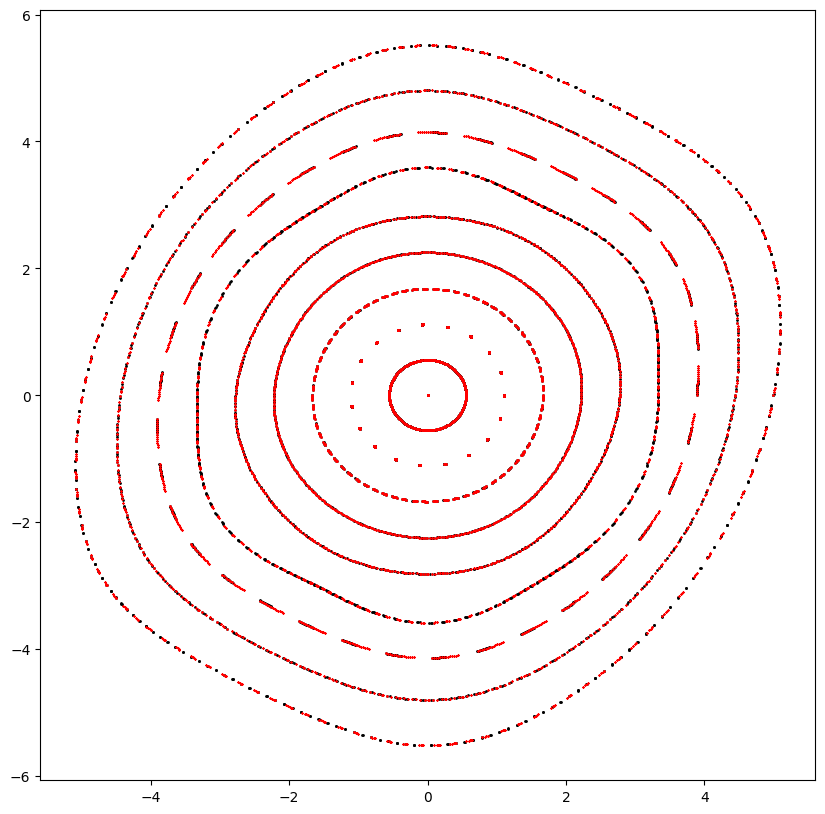

In [6]:
# Compare phase space trajectories
# Note, change order to observe convergence

plt.figure(figsize=(10, 10))

# Direct tracking

x = torch.linspace(0.0, 5.0, 10, dtype=dtype, device=device)
x = torch.stack([x, *3*[torch.zeros_like(x)]]).T

count = 512
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: ring(x))(x)

table = torch.stack(table).swapaxes(0, -1)
qx, px, *_ = table

for q, p in zip(qx.cpu().numpy(), px.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)

# Table tracking
# Note, table representation is not symplectic
    
x = torch.linspace(0.0, 5.0, 10, dtype=dtype, device=device)
x = torch.stack([x, *3*[torch.zeros_like(x)]]).T

count = 512
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: nd.evaluate(t, [x]))(x)

table = torch.stack(table).swapaxes(0, -1)
qx, px, *_ = table

for q, p in zip(qx.cpu().numpy(), px.cpu().numpy()):
    plt.scatter(q, p, color='red', marker='x', s=1)
    
plt.show()

# Example-06: Fixed point

In [1]:
# In this example fixed points are computed for a simple symplectic nonlinear transformation
# Fixed point are computed with Newton root search

In [2]:
# Import

import numpy
import torch

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set forward & inverse mappings

mu = 2.0*numpy.pi*torch.tensor(1/3 - 0.01, dtype=dtype)
kq, ks, ko = torch.tensor([0.0, 0.25, -0.25], dtype=dtype)

def forward(x):
    q, p = x
    q, p = q*mu.cos() + p*mu.sin(), p*mu.cos() - q*mu.sin()
    q, p = q, p + (kq*q + ks*q**2 + ko*q**3)
    return torch.stack([q, p])

def inverse(x):
    q, p = x
    q, p = q, p - (kq*q + ks*q**2 + ko*q**3)
    q, p = q*mu.cos() - p*mu.sin(), p*mu.cos() + q*mu.sin()
    return torch.stack([q, p])

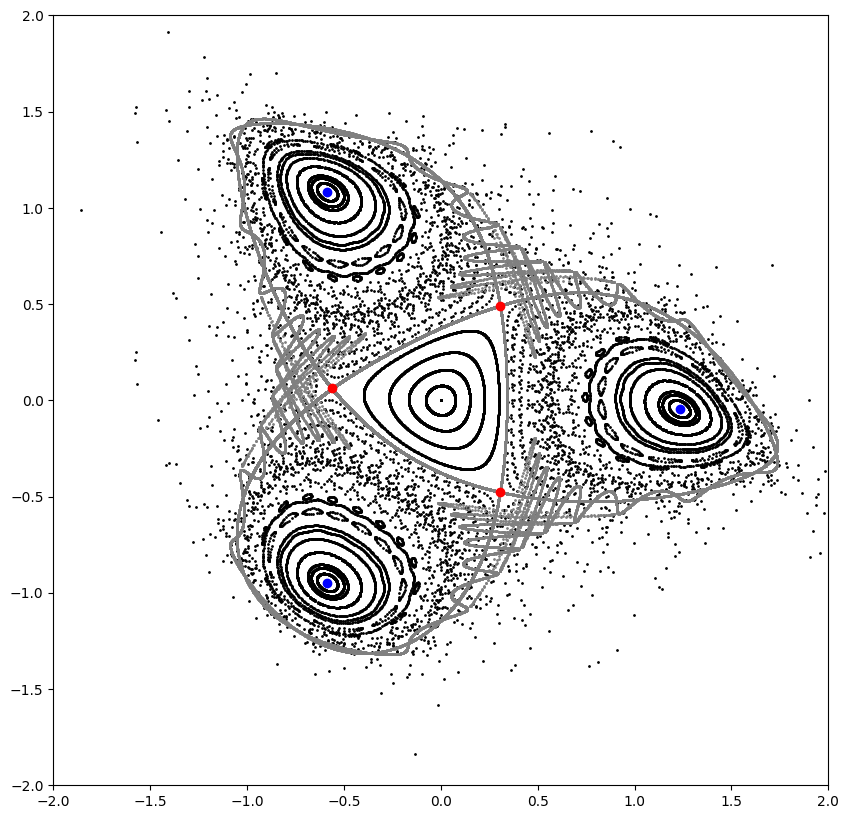

In [5]:
# Compute period three fixed points

# Set fixed point period

period = 3

# Set tolerance epsilon

epsilon = 1.0E-12

# Set random initial points

points = 4.0*torch.rand((128, 2), dtype=dtype, device=device) - 2.0

# Perform 512 root search iterations for each initial point

points = torch.func.vmap(lambda point: nd.fixed_point(512, forward, point, power=period))(points)

# Clean points (remove nans, duplicates, points from the same chain)

points = nd.clean_point(period, forward, points, epsilon=epsilon)

# Generate fixed point chains

chains = torch.func.vmap(lambda point: nd.chain_point(period, forward, point))(points)

# Classify fixed point chains (elliptic vs hyperbolic)
# Generate initials for hyperbolic fixed points using corresponding eigenvectors

kinds = []
for chain in chains:
    point, *_ = chain
    values, vectors = torch.linalg.eig(nd.matrix(period, forward, point))
    kind = all(values.log().real < epsilon)
    kinds.append(kind)
    if not kind:
        lines = [point + vector*torch.linspace(-epsilon, +epsilon, 1024, dtype=dtype).reshape(-1, 1) for vector in vectors.real.T]
        lines = torch.stack(lines)
        
# Plot phase space

x = torch.linspace(0.0, 1.5, 21, dtype=dtype, device=device)
x = torch.stack([x, torch.zeros_like(x)]).T

count = 1024
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: forward(x))(x)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table

plt.figure(figsize=(10, 10))
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)

for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)
    
# Plot (approximated) stable and unstable  manifolds of hyperbolic fixed points

count = 310

for line in lines:
    
    x = torch.clone(line)
    table = []
    for _ in range(count):
        table.append(x)
        x = torch.func.vmap(lambda x: forward(x))(x)
    table = torch.stack(table).swapaxes(0, -1)
    qs, ps = table
    for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
        plt.scatter(q, p, color='gray', marker='o', s=1)
        
    x = torch.clone(line)
    table = []
    for _ in range(count):
        table.append(x)
        x = torch.func.vmap(lambda x: inverse(x))(x)
    table = torch.stack(table).swapaxes(0, -1)
    qs, ps = table
    for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
        plt.scatter(q, p, color='gray', marker='o', s=1)
        
# Plot chains

for chain, kind in zip(chains, kinds):
    plt.scatter(*chain.T, color = {True:'blue', False:'red'}[kind], marker='o')

tensor([0., 0.], dtype=torch.float64)
tensor([0., 0.], dtype=torch.float64)


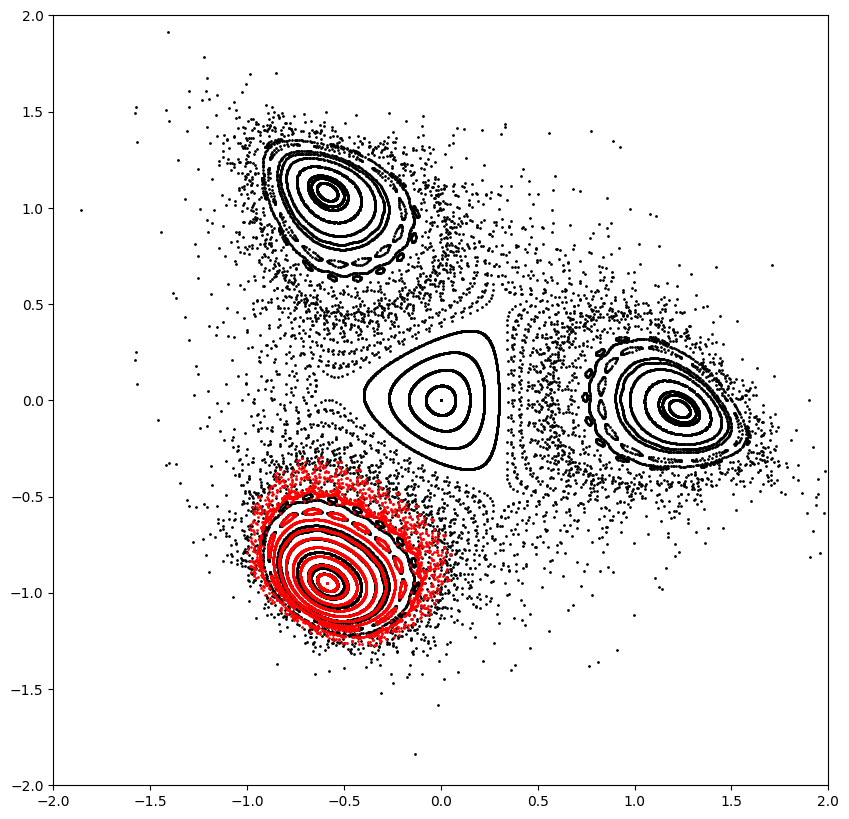

In [6]:
# Set mapping around elliptic fixed point

point, *_ = chains[kinds].squeeze()

def mapping(x):
    x = x + point
    for _ in range(period):
        x = forward(x)
    x = x - point
    return x

# Test mapping

x = torch.zeros_like(point)
print(x)
print(mapping(x))

# Plot phase space

x = torch.linspace(0.0, 1.5, 21, dtype=dtype, device=device)
x = torch.stack([x, torch.zeros_like(x)]).T

count = 1024
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: forward(x))(x)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table

plt.figure(figsize=(10, 10))
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)

for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)
    
x = torch.linspace(0.0, 0.5, 11, dtype=dtype, device=device)
x = torch.stack([x, torch.zeros_like(x)]).T

count = 1024
table = []

for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: mapping(x))(x)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table + point.reshape(2, 1, 1)

for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='red', marker='o', s=1)

# Example-07: Parametric fixed point

In [1]:
# Given a mapping depending on a set of knobs (parameters), parametric fixed points can be computed (position of a fixed point as function of parameters)
# Parametric fixed points can be used to construct responce matrices, e.g. closed orbit responce
# In this case only first order derivatives of the fixed point(s) with respect to parameters are computed
# Or higher order expansions can be computed
# In this example parametric fixed points of a symplectic mapping are computed

In [2]:
# Import

import numpy
import torch

import ndtorch.ndtorch as nd

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

from matplotlib import pyplot as plt

True


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set mapping

def mapping(x, k):
    q, p = x
    a, b = k
    q, p = q*mu.cos() + p*mu.sin(), p*mu.cos() - q*mu.sin()
    return torch.stack([q, p + a*q**2 + b*q**3])

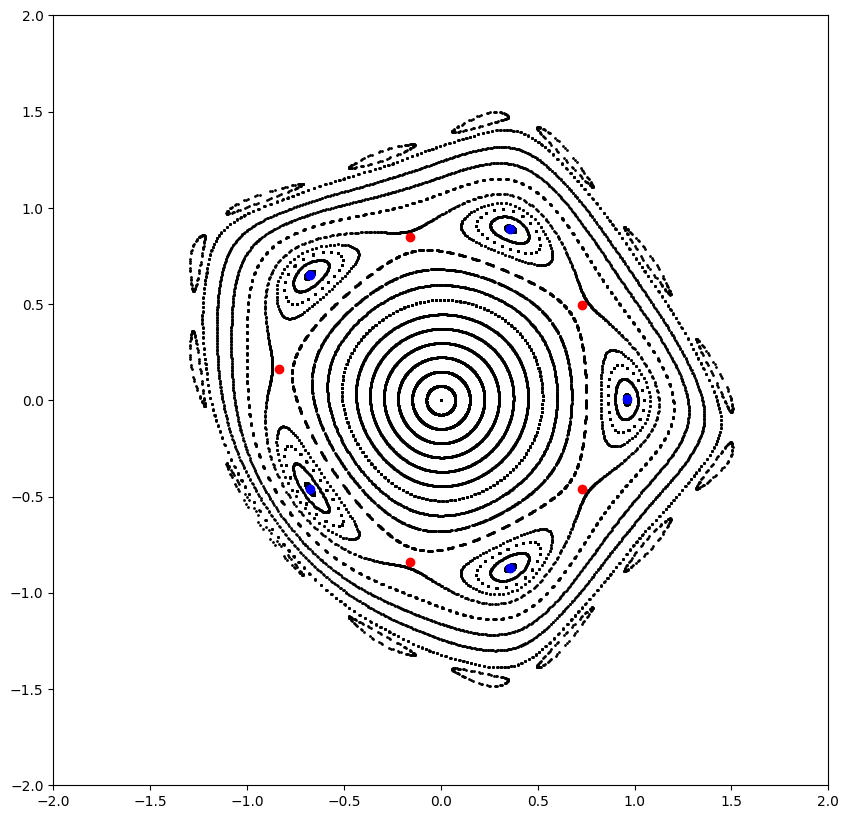

In [5]:
# Compute dynamical fixed points

# Set parameters

mu = 2.0*numpy.pi*torch.tensor(1/5 - 0.01, dtype=dtype, device=device)
k = torch.tensor([0.25, -0.25], dtype=dtype, device=device)

# Compute and plot phase space trajectories

x = torch.linspace(0.0, 1.5, 21, dtype=dtype)
x = torch.stack([x, torch.zeros_like(x)]).T

count = 1024
table = []
for _ in range(count):
    table.append(x)
    x = torch.func.vmap(lambda x: mapping(x, k))(x)
    
table = torch.stack(table).swapaxes(0, -1)
qs, ps = table

plt.figure(figsize=(10, 10))
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)
for q, p in zip(qs.cpu().numpy(), ps.cpu().numpy()):
    plt.scatter(q, p, color='black', marker='o', s=1)
    
# Set tolerance epsilon
    
epsilon = 1.0E-12

# Compute chains
    
period = 5
points = 4.0*torch.rand((128, 2), dtype=dtype, device=device) - 2.0
points = torch.func.vmap(lambda point: nd.fixed_point(512, mapping, point, k, power=period))(points)
points = nd.clean_point(period, mapping, points, k, epsilon=epsilon)
chains = torch.func.vmap(lambda point: nd.chain_point(period, mapping, point, k))(points)

# Plot chains

for chain in chains:
    point, *_ = chain
    value, vector = torch.linalg.eig(nd.matrix(period, mapping, point, k))
    color = 'blue' if all(value.log().real < epsilon) else 'red'
    plt.scatter(*chain.T, color=color, marker='o')    
    if color == 'blue':
        ep, *_ = chain
    else:
        hp, *_ = chain
        
plt.show()

In [6]:
# Compute hyperbolic fixed point for a set of knobs

dks = torch.stack(2*[torch.linspace(0.0, 0.01, 101, dtype=dtype, device=device)]).T

fps = [hp]
for dk in dks:
    *_, initial = fps
    fps.append(nd.fixed_point(128, mapping, initial, k + dk, power=period))
    
fps = torch.stack(fps)

In [7]:
# Compute parametric fixed point

# Set computation order
# Note, change order to observe convergence

order = 4
pfp = nd.parametric_fixed_point((order, ), hp, [k], mapping, power=period)

# Set period mapping and check fixed point propagation

def function(x, k):
    for _ in range(period):
        x = mapping(x, k)
    return x

out = nd.propagate((2, 2), (0, order), pfp, [k], function)
for x, y in zip(nd.flatten(pfp, target=list), nd.flatten(out, target=list)):
    print(torch.allclose(x, y))

True
True
True
True
True


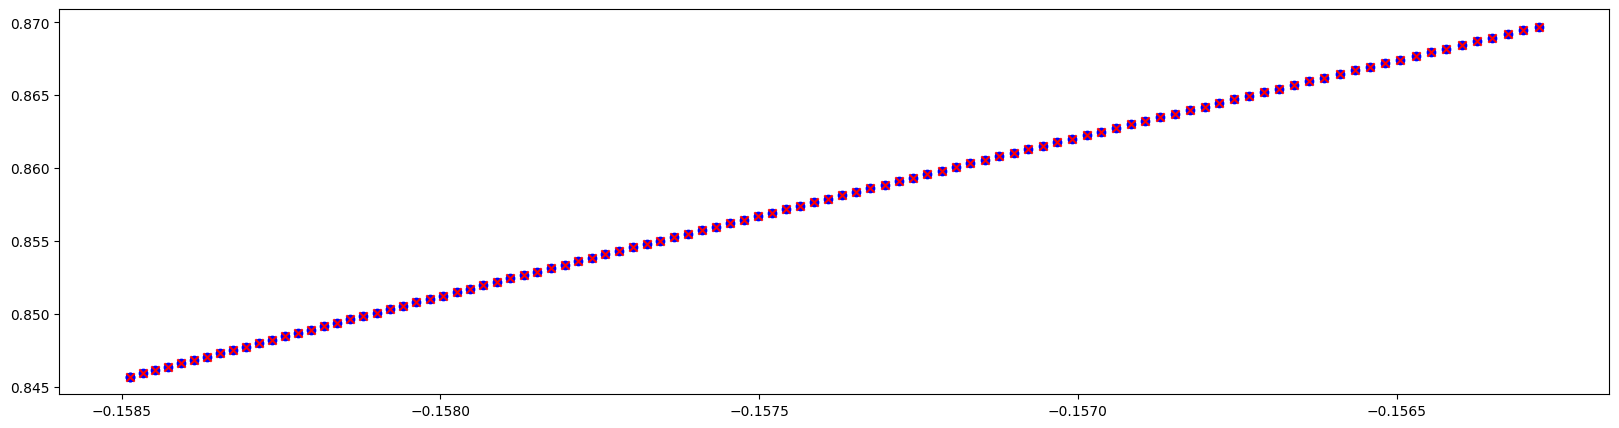

In [8]:
# Plot parametric fixed point position for a given set of knobs

out = torch.func.vmap(lambda dk: nd.evaluate(pfp, [hp, dk]))(dks)

plt.figure(figsize=(20, 5))
plt.scatter(*fps.T.cpu().numpy(), color='blue', marker='o')
plt.scatter(*out.T.cpu().numpy(), color='red', marker='x')
plt.show()